In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp

In [3]:


tickers = ["SPY","QQQ","EFA","IWM","TLT","LQD","GLD","VNQ"]

prices = yf.download(
    tickers,
    start="2015-01-01",
    end="2025-01-01",
    auto_adjust=True
)["Close"]



[*********************100%***********************]  8 of 8 completed


In [11]:
returns = np.log(prices / prices.shift(1)).dropna()
print(returns.mean())
target_return = 0.0005
n_assets = len(tickers)

# Optimize mean-variance portfolio on full sample
w_mv = optimize_mean_variance(returns, min_return=target_return)
#print("Mean-Variance Portfolio Weights:\n", w_mv)

Ticker
EFA    0.000203
GLD    0.000299
IWM    0.000299
LQD    0.000088
QQQ    0.000668
SPY    0.000486
TLT   -0.000050
VNQ    0.000190
dtype: float64


In [6]:
# Helper functions for portfolio optimization

def optimize_mean_variance(returns_df, min_return=0, Sigma=None):
    """
    Solve mean-variance optimization.
    
    Args:
        returns_df: DataFrame of returns
        min_return: Minimum expected return constraint
        Sigma: Covariance matrix (if None, computed from returns_df)
    
    Returns:
        Optimal weights array
    """
    mu = returns_df.mean().values
    if Sigma is None:
        Sigma = returns_df.cov().values
    
    n = len(mu)
    w = cp.Variable(n)
    
    constraints = [
        cp.sum(w) == 1,
        mu @ w >= min_return,
        w >= 0
    ]
    
    prob = cp.Problem(
        cp.Minimize(cp.quad_form(w, Sigma)),
        constraints
    )
    prob.solve()
    
    return w.value


def optimize_cvar(returns_df, alpha=0.95):
    """
    Solve CVaR (Conditional Value at Risk) optimization.
    
    Args:
        returns_df: DataFrame of returns
        alpha: Confidence level (0 < alpha < 1)
    
    Returns:
        Optimal weights array
    """
    R = returns_df.values
    T = R.shape[0]
    n = returns_df.shape[1]
    
    w = cp.Variable(n)
    VaR = cp.Variable()
    z = cp.Variable(T)
    
    losses = -R @ w
    
    constraints = [
        cp.sum(w) == 1,
        z >= 0,
        z >= losses - VaR,
        w >= 0
    ]
    
    objective = cp.Minimize(VaR + (1 / ((1 - alpha) * T)) * cp.sum(z))
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return w.value


def compute_performance_metrics(returns_series):
    """
    Compute performance metrics for a return series.
    
    Args:
        returns_series: Series of returns
    
    Returns:
        Dictionary with volatility, cumulative returns, drawdowns, and CVaR
    """
    cum_returns = (1 + returns_series).cumprod()
    drawdowns = cum_returns / cum_returns.cummax() - 1
    volatility = returns_series.std()
    cvar = returns_series.sort_values().iloc[:int(0.05 * len(returns_series))].mean()
    
    return {
        'cumulative': cum_returns,
        'drawdowns': drawdowns,
        'volatility': volatility,
        'cvar': cvar
    }


def plot_comparison(cum_returns_dict, title="Cumulative Returns"):
    """
    Plot comparison of multiple return series.
    
    Args:
        cum_returns_dict: Dictionary of {name: series}
        title: Plot title
    """
    plt.figure(figsize=(10, 5))
    for label, series in cum_returns_dict.items():
        plt.plot(series, label=label)
    plt.legend()
    plt.title(title)
    plt.show()


In [34]:
from sklearn.covariance import LedoitWolf

# Optimize with Ledoit-Wolf shrinkage
lw = LedoitWolf().fit(returns)
cov_shrink = lw.covariance_
w_mv_shrink = optimize_mean_variance(returns, min_return=target_return, Sigma=cov_shrink)
print("Mean-Variance Weights with Ledoit-Wolf Shrinkage:\n", w_mv_shrink)

Mean-Variance Weights with Ledoit-Wolf Shrinkage:
 [5.05822464e-24 4.55653740e-01 3.99773122e-24 6.31548295e-24
 5.44346260e-01 1.96370865e-24 7.81854232e-24 5.17830942e-24]


In [35]:
# Optimize CVaR portfolio on full sample
alpha = 0.95
w_cvar = optimize_cvar(returns, alpha=alpha)
print("CVaR-Optimized Portfolio Weights:\n", w_cvar)

CVaR-Optimized Portfolio Weights:
 [2.05645441e-02 1.91387433e-01 4.69064353e-13 7.13534220e-01
 4.29708104e-13 7.45138033e-02 3.25206685e-13 6.71892976e-14]


Mean-Variance Volatility: 0.008727043012172434
CVaR Volatility: 0.005080985836949611
Mean-Variance CVaR: -0.020674367635240505
CVaR Portfolio CVaR: -0.011475784067035495


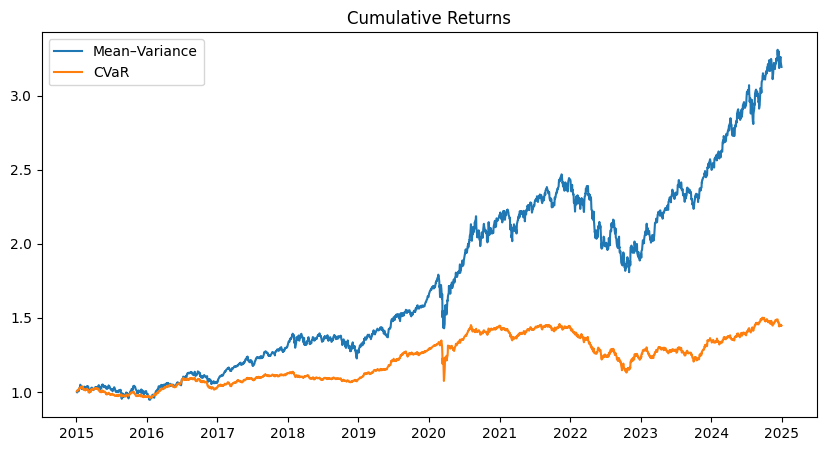

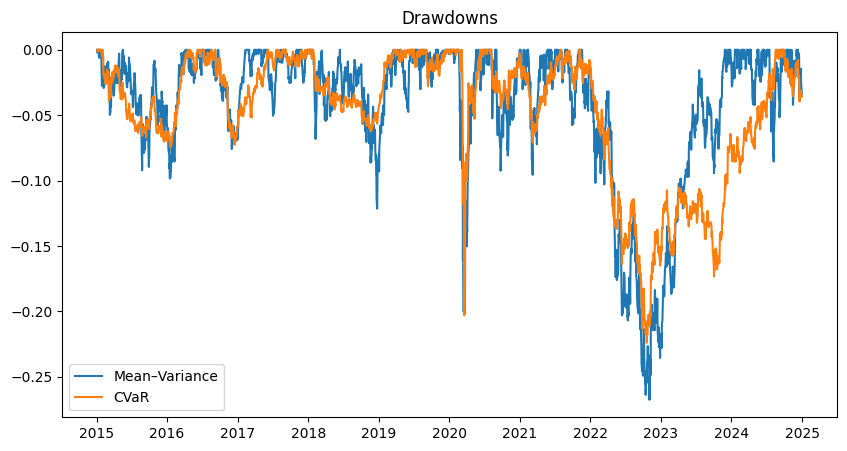

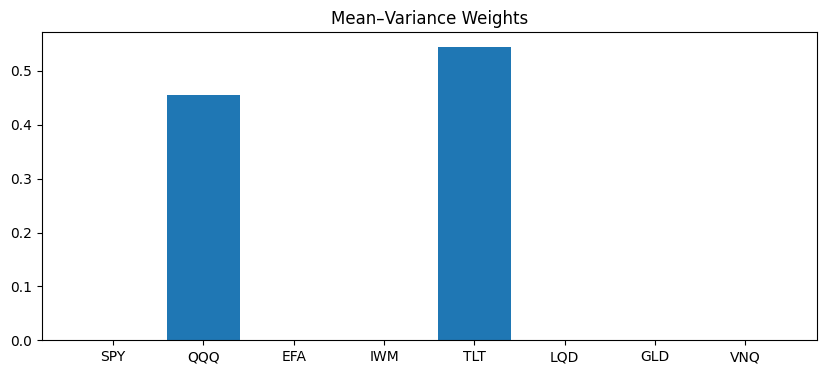

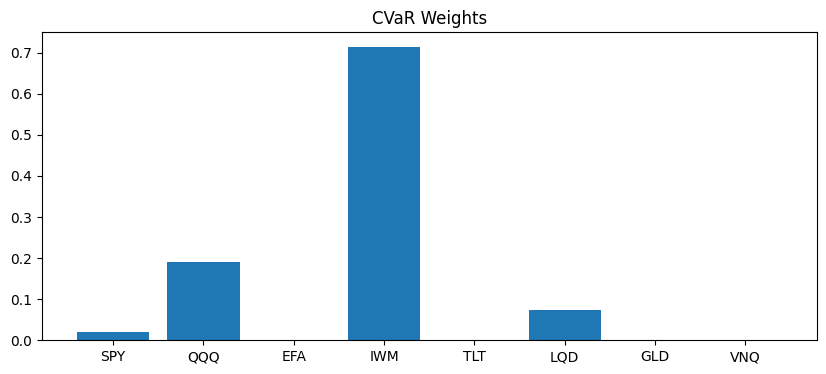

In [36]:
# Compute returns and performance metrics
ret_mv = pd.Series(returns.values @ w_mv, index=returns.index)
ret_cvar = pd.Series(returns.values @ w_cvar, index=returns.index)

metrics_mv = compute_performance_metrics(ret_mv)
metrics_cvar = compute_performance_metrics(ret_cvar)

print("Mean-Variance Volatility:", metrics_mv['volatility'])
print("CVaR Volatility:", metrics_cvar['volatility'])
print("Mean-Variance CVaR:", metrics_mv['cvar'])
print("CVaR Portfolio CVaR:", metrics_cvar['cvar'])

# Plot comparisons
plot_comparison(
    {"Mean–Variance": metrics_mv['cumulative'], "CVaR": metrics_cvar['cumulative']},
    "Cumulative Returns"
)
plot_comparison(
    {"Mean–Variance": metrics_mv['drawdowns'], "CVaR": metrics_cvar['drawdowns']},
    "Drawdowns"
)

# Plot weights
plt.figure(figsize=(10, 4))
plt.bar(tickers, w_mv)
plt.title("Mean–Variance Weights")
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(tickers, w_cvar)
plt.title("CVaR Weights")
plt.show()

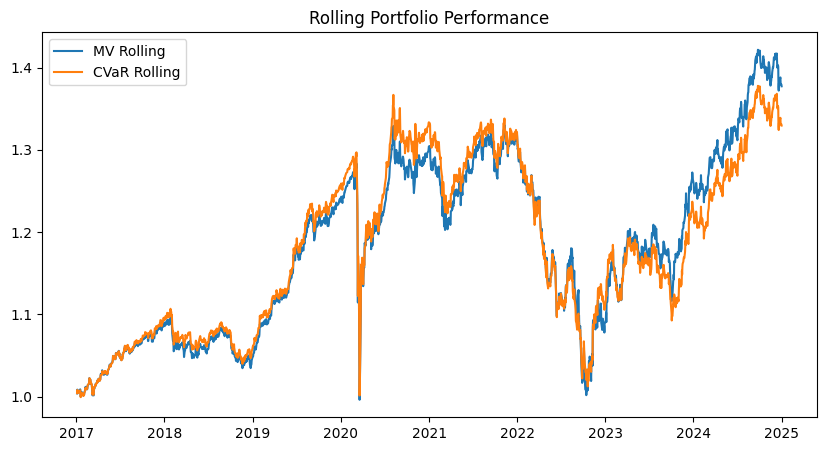

In [37]:
# Rolling window backtesting
window = 504
rebalance_step = 21  # ~1 month
alpha = 0.95

ret_mv_roll = []
ret_cvar_roll = []
dates = []

for start in range(window, len(returns), rebalance_step):
    train = returns.iloc[start - window:start]
    test = returns.iloc[start:start + rebalance_step]

    if len(test) == 0:
        break

    # Optimize on training set
    w_mv_opt = optimize_mean_variance(train, min_return=0)
    w_cvar_opt = optimize_cvar(train, alpha=alpha)

    # Apply to test set
    ret_mv_roll.extend(test.values @ w_mv_opt)
    ret_cvar_roll.extend(test.values @ w_cvar_opt)
    dates.extend(test.index)

ret_mv_roll = pd.Series(ret_mv_roll, index=dates)
ret_cvar_roll = pd.Series(ret_cvar_roll, index=dates)

metrics_mv_roll = compute_performance_metrics(ret_mv_roll)
metrics_cvar_roll = compute_performance_metrics(ret_cvar_roll)

plot_comparison(
    {"MV Rolling": metrics_mv_roll['cumulative'], "CVaR Rolling": metrics_cvar_roll['cumulative']},
    "Rolling Portfolio Performance"
)

Regime-switching strategy volatility: 0.005890692108320967
Regime-switching strategy CVaR: -0.013850274724866352


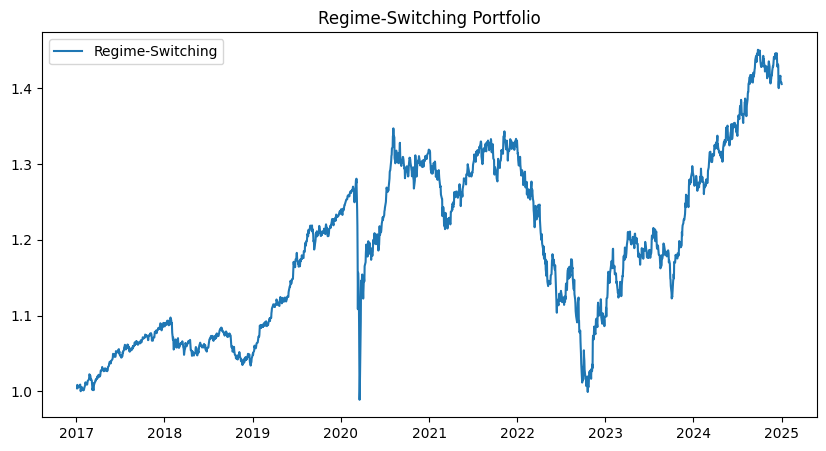

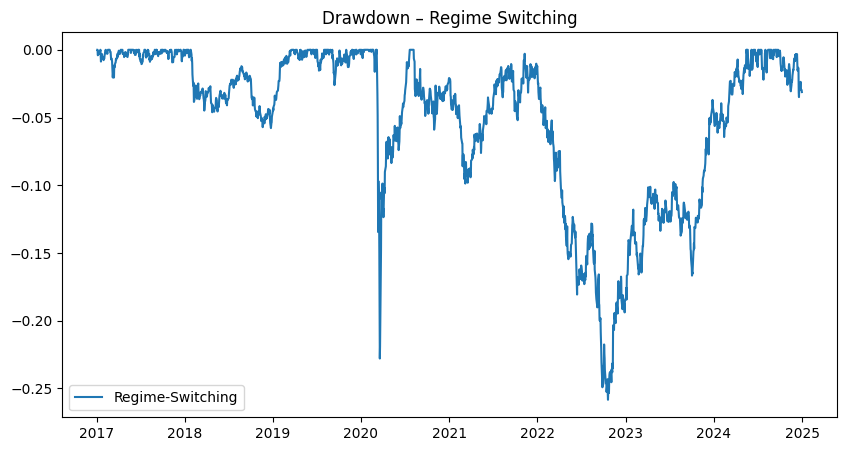

In [39]:
# Regime-switching strategy (calm = Mean-Variance, stress = CVaR)

# Compute market regimes based on cross-sectional volatility
daily_vol = returns.std(axis=1)
vol_signal = daily_vol.rolling(21).mean()
threshold = vol_signal.quantile(0.8)
regime = (vol_signal > threshold).astype(int)  # 0 = calm, 1 = stress

# Rolling window backtesting with regime switching
window = 504
rebalance_step = 21
alpha = 0.95

ret_controlled = []
dates = []

for t in range(window, len(returns), rebalance_step):
    train = returns.iloc[t - window:t]
    test = returns.iloc[t:t + rebalance_step]

    if len(test) == 0:
        break

    current_regime = regime.iloc[t]

    # Switch optimization based on regime
    if current_regime == 0:
        # Calm regime: use Mean-Variance
        w = optimize_mean_variance(train, min_return=0)
    else:
        # Stress regime: use CVaR
        w = optimize_cvar(train, alpha=alpha)

    ret_controlled.extend(test.values @ w)
    dates.extend(test.index)

ret_controlled = pd.Series(ret_controlled, index=dates)
metrics_controlled = compute_performance_metrics(ret_controlled)
print("Regime-switching strategy volatility:", metrics_controlled['volatility'])
print("Regime-switching strategy CVaR:", metrics_controlled['cvar'])

# Use helper functions to plot regime-switching results
plot_comparison(
    {"Regime-Switching": metrics_controlled['cumulative']},
    "Regime-Switching Portfolio"
)
plot_comparison(
    {"Regime-Switching": metrics_controlled['drawdowns']},
    "Drawdown – Regime Switching"
)


ROLLING STRATEGIES COMPARISON: REGIME-SWITCHING vs MV vs CVaR

--------------------------------------------------------------------------------
Strategy             Volatility         CVaR (5%)          Total Return      
--------------------------------------------------------------------------------
MV Rolling           0.00597            -0.01409           37.72             %
CVaR Rolling         0.00583            -0.01363           32.95             %
Regime-Switching     0.00589            -0.01385           40.56             %
--------------------------------------------------------------------------------

Risk-Adjusted Performance Metrics:
--------------------------------------------------------------------------------
Strategy             Sharpe Ratio       Max Drawdown       Return/Volatility 
--------------------------------------------------------------------------------
MV Rolling           0.471              -24.70            % 0.0297            
CVaR Rolling         0.

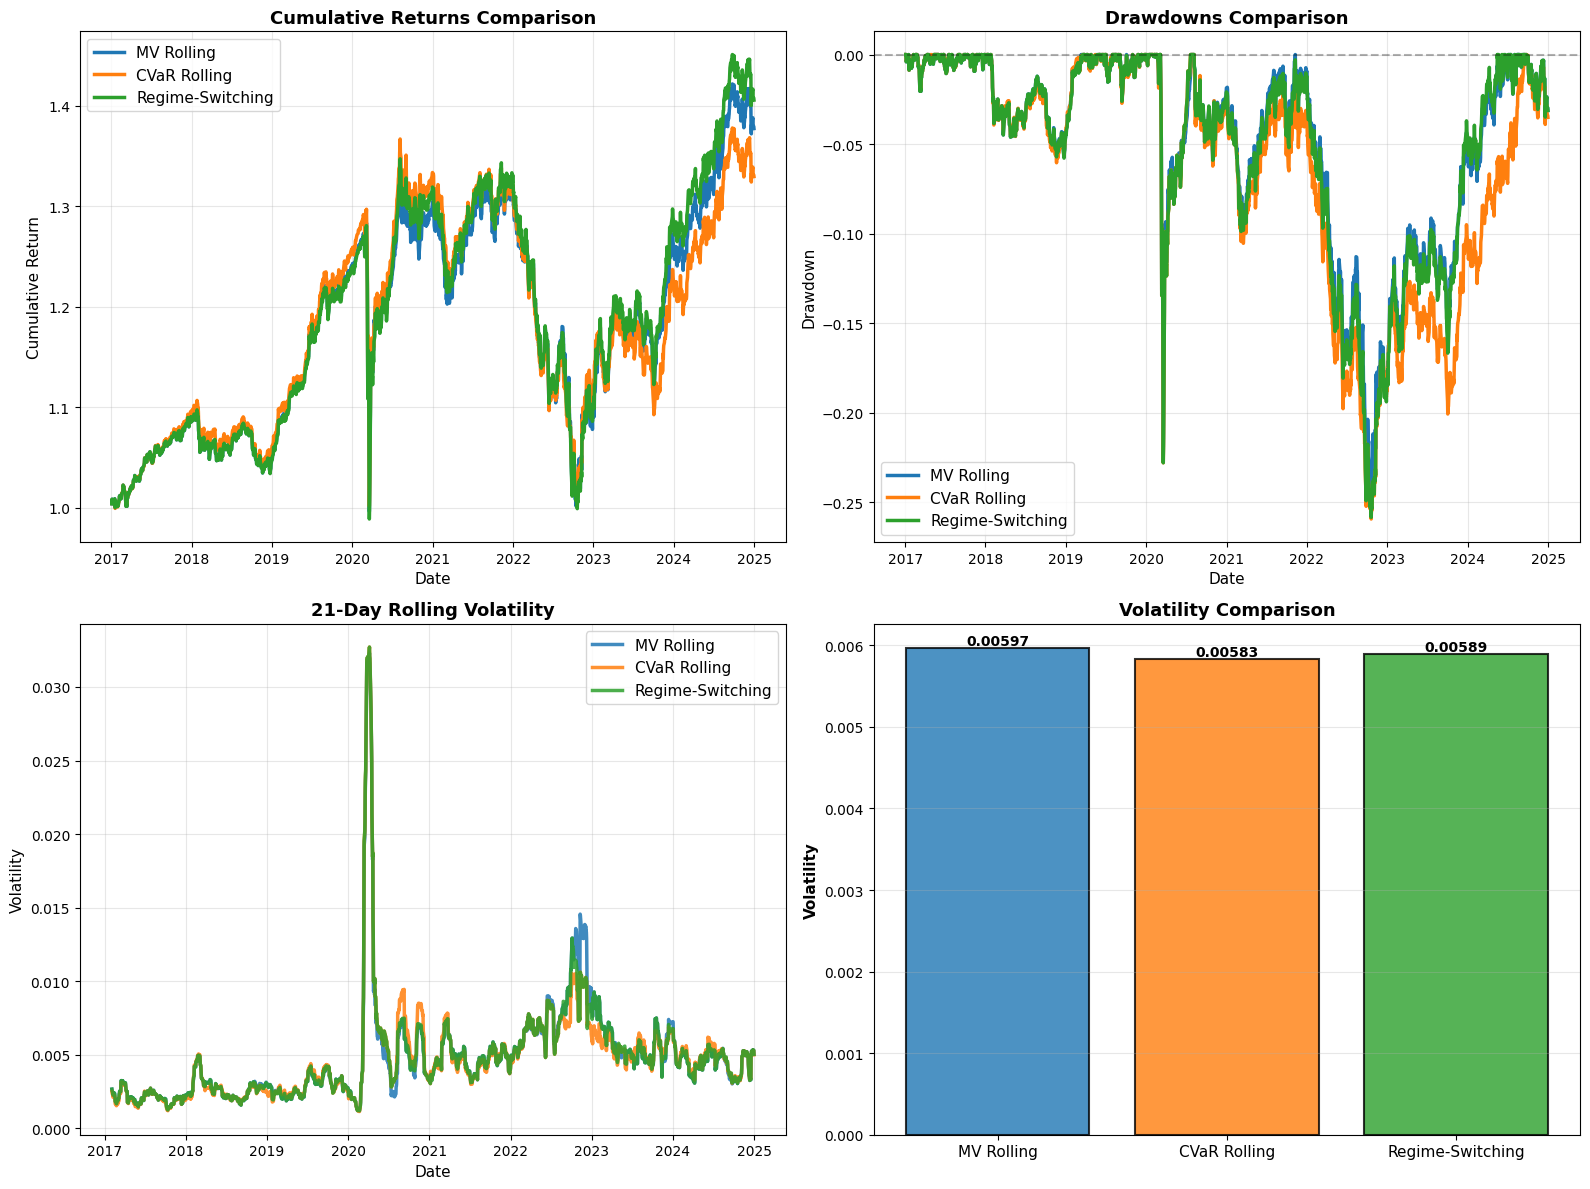


KEY FINDINGS

Best Volatility: CVaR Rolling (0.00583)
Best CVaR: MV Rolling (-0.01409)
Best Total Return: Regime-Switching (40.56%)
Best Max Drawdown: MV Rolling (-24.70%)

--------------------------------------------------------------------------------
REGIME-SWITCHING STRATEGY ANALYSIS
--------------------------------------------------------------------------------

Volatility Comparison:
  vs MV Rolling: -1.25%
  vs CVaR Rolling: +0.96%

Total Return Comparison:
  Regime-Switching: 40.56%
  MV Rolling: 37.72%
  CVaR Rolling: 32.95%
  Regime-Switching vs Best: +2.06%

Drawdown Comparison:
  Regime-Switching Max DD: -25.83%
  MV Rolling Max DD: -24.70%
  CVaR Rolling Max DD: -25.92%

CONCLUSION
✗ Regime-switching has higher volatility than the best rolling strategy
✓ Regime-switching achieves competitive returns
✗ Regime-switching has worse drawdown control


In [40]:
# Comprehensive Comparison: Regime-Switching vs Rolling Strategies

print("\n" + "="*80)
print("ROLLING STRATEGIES COMPARISON: REGIME-SWITCHING vs MV vs CVaR")
print("="*80)

# Prepare comparison data
strategies_comparison = {
    'MV Rolling': metrics_mv_roll,
    'CVaR Rolling': metrics_cvar_roll,
    'Regime-Switching': metrics_controlled
}

# Print performance table
print("\n" + "-"*80)
print(f"{'Strategy':<20} {'Volatility':<18} {'CVaR (5%)':<18} {'Total Return':<18}")
print("-"*80)

for name, metrics in strategies_comparison.items():
    vol = metrics['volatility']
    cvar = metrics['cvar']
    total_ret = (metrics['cumulative'].iloc[-1] - 1) * 100
    print(f"{name:<20} {vol:<18.5f} {cvar:<18.5f} {total_ret:<18.2f}%")

print("-"*80)

# Calculate risk-adjusted metrics
print("\nRisk-Adjusted Performance Metrics:")
print("-"*80)
print(f"{'Strategy':<20} {'Sharpe Ratio':<18} {'Max Drawdown':<18} {'Return/Volatility':<18}")
print("-"*80)

returns_dict_comparison = {
    'MV Rolling': ret_mv_roll,
    'CVaR Rolling': ret_cvar_roll,
    'Regime-Switching': ret_controlled
}

for name, ret_series in returns_dict_comparison.items():
    sharpe = (ret_series.mean() / ret_series.std()) * np.sqrt(252)
    max_dd = strategies_comparison[name]['drawdowns'].min() * 100
    ret_vol_ratio = (ret_series.mean() / ret_series.std())
    print(f"{name:<20} {sharpe:<18.3f} {max_dd:<18.2f}% {ret_vol_ratio:<18.4f}")

print("-"*80)

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Cumulative Returns Comparison
ax = axes[0, 0]
for name, metrics in strategies_comparison.items():
    ax.plot(metrics['cumulative'], label=name, linewidth=2.5)
ax.set_title('Cumulative Returns Comparison', fontsize=13, fontweight='bold')
ax.set_ylabel('Cumulative Return', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

# Plot 2: Drawdowns Comparison
ax = axes[0, 1]
for name, metrics in strategies_comparison.items():
    ax.plot(metrics['drawdowns'], label=name, linewidth=2.5)
ax.set_title('Drawdowns Comparison', fontsize=13, fontweight='bold')
ax.set_ylabel('Drawdown', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.legend(fontsize=11, loc='lower left')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Plot 3: Rolling 21-Day Volatility
ax = axes[1, 0]
vol_window = 21
for name, ret_series in returns_dict_comparison.items():
    rolling_vol = ret_series.rolling(vol_window).std()
    ax.plot(rolling_vol, label=name, linewidth=2.5, alpha=0.85)
ax.set_title(f'{vol_window}-Day Rolling Volatility', fontsize=13, fontweight='bold')
ax.set_ylabel('Volatility', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 4: Metrics Comparison Bar Chart
ax = axes[1, 1]
strategy_names = list(strategies_comparison.keys())
volatilities = [strategies_comparison[s]['volatility'] for s in strategy_names]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

x_pos = np.arange(len(strategy_names))
bars = ax.bar(x_pos, volatilities, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Volatility', fontsize=11, fontweight='bold')
ax.set_title('Volatility Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(strategy_names, fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, vol in zip(bars, volatilities):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{vol:.5f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary Analysis
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# Find best strategy for each metric
best_vol_strategy = min(strategies_comparison.items(), key=lambda x: x[1]['volatility'])
best_cvar_strategy = min(strategies_comparison.items(), key=lambda x: x[1]['cvar'])
best_return_strategy = max(strategies_comparison.items(), key=lambda x: x[1]['cumulative'].iloc[-1])
best_dd_strategy = max(strategies_comparison.items(), key=lambda x: x[1]['drawdowns'].min())

print(f"\nBest Volatility: {best_vol_strategy[0]} ({best_vol_strategy[1]['volatility']:.5f})")
print(f"Best CVaR: {best_cvar_strategy[0]} ({best_cvar_strategy[1]['cvar']:.5f})")
print(f"Best Total Return: {best_return_strategy[0]} ({(best_return_strategy[1]['cumulative'].iloc[-1] - 1)*100:.2f}%)")
print(f"Best Max Drawdown: {best_dd_strategy[0]} ({best_dd_strategy[1]['drawdowns'].min()*100:.2f}%)")

# Regime-switching specific analysis
print("\n" + "-"*80)
print("REGIME-SWITCHING STRATEGY ANALYSIS")
print("-"*80)

rs_vol = metrics_controlled['volatility']
mv_vol = metrics_mv_roll['volatility']
cvar_vol = metrics_cvar_roll['volatility']

print(f"\nVolatility Comparison:")
print(f"  vs MV Rolling: {((rs_vol/mv_vol - 1)*100):+.2f}%")
print(f"  vs CVaR Rolling: {((rs_vol/cvar_vol - 1)*100):+.2f}%")

rs_return = metrics_controlled['cumulative'].iloc[-1]
mv_return = metrics_mv_roll['cumulative'].iloc[-1]
cvar_return = metrics_cvar_roll['cumulative'].iloc[-1]

print(f"\nTotal Return Comparison:")
print(f"  Regime-Switching: {(rs_return - 1)*100:.2f}%")
print(f"  MV Rolling: {(mv_return - 1)*100:.2f}%")
print(f"  CVaR Rolling: {(cvar_return - 1)*100:.2f}%")
print(f"  Regime-Switching vs Best: {((rs_return - max(mv_return, cvar_return)) / max(mv_return, cvar_return) * 100):+.2f}%")

print(f"\nDrawdown Comparison:")
print(f"  Regime-Switching Max DD: {metrics_controlled['drawdowns'].min()*100:.2f}%")
print(f"  MV Rolling Max DD: {metrics_mv_roll['drawdowns'].min()*100:.2f}%")
print(f"  CVaR Rolling Max DD: {metrics_cvar_roll['drawdowns'].min()*100:.2f}%")

# Conclusion
print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
if rs_vol <= min(mv_vol, cvar_vol):
    print("✓ Regime-switching reduces volatility compared to both rolling strategies")
else:
    print("✗ Regime-switching has higher volatility than the best rolling strategy")

if rs_return >= max(mv_return, cvar_return) * 0.95:  # Within 5%
    print("✓ Regime-switching achieves competitive returns")
else:
    print("✗ Regime-switching underperforms in total returns")

if metrics_controlled['drawdowns'].min() >= max(metrics_mv_roll['drawdowns'].min(), metrics_cvar_roll['drawdowns'].min()) * 0.95:
    print("✓ Regime-switching controls drawdowns effectively")
else:
    print("✗ Regime-switching has worse drawdown control")


TAIL-AWARE OPTIMIZATION STRATEGIES

1. THREE-REGIME STRATEGY (Calm, Normal, Stress)
--------------------------------------------------------------------------------
Regime thresholds: [0.00593422 0.00777287]
Three-Regime Strategy - Volatility: 0.00585
Three-Regime Strategy - CVaR: -0.01371
Three-Regime Strategy - Total Return: 35.74%

2. EXTREME CVaR STRATEGY (1% tail focus)
--------------------------------------------------------------------------------
Extreme CVaR (1%) - Volatility: 0.00623
Extreme CVaR (1%) - CVaR: -0.01484
Extreme CVaR (1%) - Total Return: 32.37%

3. DOWNSIDE DEVIATION STRATEGY
--------------------------------------------------------------------------------
Downside Deviation - Volatility: 0.00578
Downside Deviation - CVaR: -0.01344
Downside Deviation - Total Return: 36.69%

4. TAIL-FOCUSED ADAPTIVE STRATEGY
--------------------------------------------------------------------------------
Tail-Adaptive Strategy - Volatility: 0.00587
Tail-Adaptive Strategy - CVaR: 

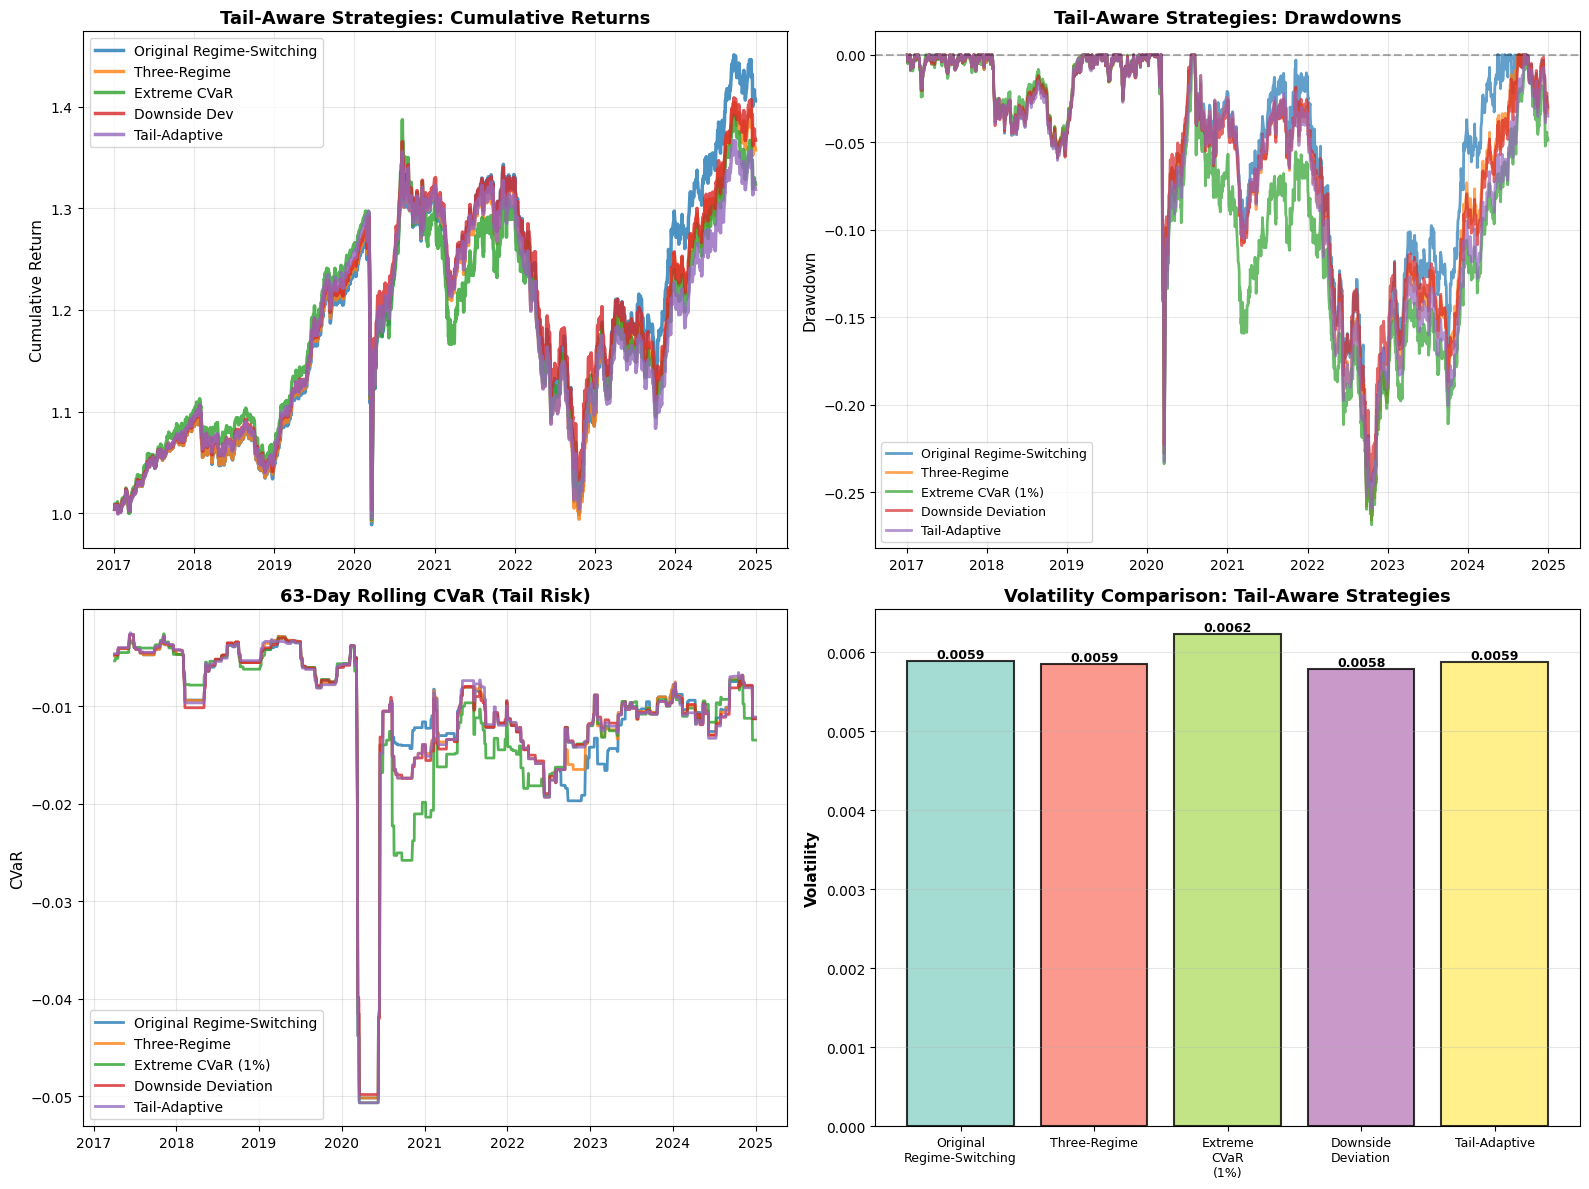


TAIL EVENT HANDLING ANALYSIS

Best Volatility Control: Downside Deviation (0.00578)
Best CVaR (Tail Risk): Extreme CVaR (1%) (-0.01484)
Best Max Drawdown: Extreme CVaR (1%) (-26.86%)

Recommendation:
✓ Switch to Extreme CVaR (1%) - better tail risk management
  - -7.2% better CVaR


In [45]:
# Tail-Aware Portfolio Optimization Approaches

print("\n" + "="*80)
print("TAIL-AWARE OPTIMIZATION STRATEGIES")
print("="*80)

# 1. Multi-regime strategy with 3 volatility states (calm, normal, stress)
print("\n1. THREE-REGIME STRATEGY (Calm, Normal, Stress)")
print("-"*80)

vol_quantiles = [0.33, 0.67]  # Split into thirds
regime_thresholds = vol_signal.quantile(vol_quantiles).values
print(f"Regime thresholds: {regime_thresholds}")

# Assign 3 regimes based on volatility quantiles
regime_3 = np.zeros(len(vol_signal), dtype=int)
regime_3[vol_signal > regime_thresholds[1]] = 2  # Stress
regime_3[(vol_signal > regime_thresholds[0]) & (vol_signal <= regime_thresholds[1])] = 1  # Normal

ret_controlled_3regime = []
dates_3regime = []

for t in range(window, len(returns), rebalance_step):
    train = returns.iloc[t - window:t]
    test = returns.iloc[t:t + rebalance_step]

    if len(test) == 0:
        break

    current_regime_3 = regime_3[t]

    # Three-way regime switching
    if current_regime_3 == 0:
        # Calm: Pure Mean-Variance
        w = optimize_mean_variance(train, min_return=0)
    elif current_regime_3 == 1:
        # Normal: Blend MV and CVaR (equal weight)
        w_mv = optimize_mean_variance(train, min_return=0)
        w_cvar = optimize_cvar(train, alpha=alpha)
        w = (w_mv + w_cvar) / 2
    else:
        # Stress: Pure CVaR
        w = optimize_cvar(train, alpha=alpha)

    ret_controlled_3regime.extend(test.values @ w)
    dates_3regime.extend(test.index)

ret_controlled_3regime = pd.Series(ret_controlled_3regime, index=dates_3regime)
metrics_3regime = compute_performance_metrics(ret_controlled_3regime)

print(f"Three-Regime Strategy - Volatility: {metrics_3regime['volatility']:.5f}")
print(f"Three-Regime Strategy - CVaR: {metrics_3regime['cvar']:.5f}")
print(f"Three-Regime Strategy - Total Return: {(metrics_3regime['cumulative'].iloc[-1] - 1)*100:.2f}%")

# 2. Extreme CVaR (focus on extreme tail - 1% instead of 5%)
print("\n2. EXTREME CVaR STRATEGY (1% tail focus)")
print("-"*80)

def optimize_extreme_cvar(returns_df, alpha_extreme=0.99):
    """Focus on the most extreme losses (1% tail)"""
    R = returns_df.values
    T = R.shape[0]
    n = returns_df.shape[1]
    
    w = cp.Variable(n)
    VaR = cp.Variable()
    z = cp.Variable(T)
    
    losses = -R @ w
    
    constraints = [
        cp.sum(w) == 1,
        z >= 0,
        z >= losses - VaR,
        w >= 0
    ]
    
    objective = cp.Minimize(VaR + (1 / ((1 - alpha_extreme) * T)) * cp.sum(z))
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return w.value

ret_extreme_cvar = []
dates_extreme = []

for t in range(window, len(returns), rebalance_step):
    train = returns.iloc[t - window:t]
    test = returns.iloc[t:t + rebalance_step]

    if len(test) == 0:
        break

    # Always use extreme CVaR
    w = optimize_extreme_cvar(train, alpha_extreme=0.99)
    
    ret_extreme_cvar.extend(test.values @ w)
    dates_extreme.extend(test.index)

ret_extreme_cvar = pd.Series(ret_extreme_cvar, index=dates_extreme)
metrics_extreme_cvar = compute_performance_metrics(ret_extreme_cvar)

print(f"Extreme CVaR (1%) - Volatility: {metrics_extreme_cvar['volatility']:.5f}")
print(f"Extreme CVaR (1%) - CVaR: {metrics_extreme_cvar['cvar']:.5f}")
print(f"Extreme CVaR (1%) - Total Return: {(metrics_extreme_cvar['cumulative'].iloc[-1] - 1)*100:.2f}%")

# 3. Downside Deviation Optimization (focus on negative returns only)
print("\n3. DOWNSIDE DEVIATION STRATEGY")
print("-"*80)

def optimize_downside_risk(returns_df, min_return=0):
    """
    Minimize semi-variance (sum of squared downside returns).
    Focuses on negative deviations below target return.
    """
    R = returns_df.values
    T = R.shape[0]
    n = returns_df.shape[1]
    
    w = cp.Variable(n)
    downside_returns = R @ w - min_return
    
    constraints = [
        cp.sum(w) == 1,
        w >= 0
    ]
    
    # Minimize semi-variance: sum of squared negative returns
    obj = cp.sum(cp.square(cp.maximum(-downside_returns, 0)))
    
    prob = cp.Problem(
        cp.Minimize(obj),
        constraints
    )
    prob.solve()
    
    return w.value

ret_downside = []
dates_downside = []

for t in range(window, len(returns), rebalance_step):
    train = returns.iloc[t - window:t]
    test = returns.iloc[t:t + rebalance_step]

    if len(test) == 0:
        break

    w = optimize_downside_risk(train, min_return=0)
    
    ret_downside.extend(test.values @ w)
    dates_downside.extend(test.index)

ret_downside = pd.Series(ret_downside, index=dates_downside)
metrics_downside = compute_performance_metrics(ret_downside)

print(f"Downside Deviation - Volatility: {metrics_downside['volatility']:.5f}")
print(f"Downside Deviation - CVaR: {metrics_downside['cvar']:.5f}")
print(f"Downside Deviation - Total Return: {(metrics_downside['cumulative'].iloc[-1] - 1)*100:.2f}%")

# 4. Adaptive Tail-Focused Regime (switches based on tail metrics, not just volatility)
print("\n4. TAIL-FOCUSED ADAPTIVE STRATEGY")
print("-"*80)

# Use rolling skewness and kurtosis to detect tail risk
rolling_skew = returns.rolling(21).skew().mean(axis=1)
rolling_kurt = returns.rolling(21).kurt().mean(axis=1)

# Regime: high tail risk if negative skew + high kurtosis
tail_risk_signal = (rolling_skew < -0.2).astype(int) & (rolling_kurt > 3).astype(int)

ret_tail_adaptive = []
dates_tail = []

for t in range(window, len(returns), rebalance_step):
    train = returns.iloc[t - window:t]
    test = returns.iloc[t:t + rebalance_step]

    if len(test) == 0:
        break

    tail_risk = tail_risk_signal.iloc[t]

    if tail_risk == 1:
        # High tail risk: use Extreme CVaR
        w = optimize_extreme_cvar(train, alpha_extreme=0.99)
    else:
        # Normal: use standard CVaR
        w = optimize_cvar(train, alpha=0.95)

    ret_tail_adaptive.extend(test.values @ w)
    dates_tail.extend(test.index)

ret_tail_adaptive = pd.Series(ret_tail_adaptive, index=dates_tail)
metrics_tail_adaptive = compute_performance_metrics(ret_tail_adaptive)

print(f"Tail-Adaptive Strategy - Volatility: {metrics_tail_adaptive['volatility']:.5f}")
print(f"Tail-Adaptive Strategy - CVaR: {metrics_tail_adaptive['cvar']:.5f}")
print(f"Tail-Adaptive Strategy - Total Return: {(metrics_tail_adaptive['cumulative'].iloc[-1] - 1)*100:.2f}%")

# Comprehensive comparison of all tail-aware strategies
print("\n" + "="*80)
print("TAIL-AWARE STRATEGIES COMPARISON")
print("="*80)

tail_strategies = {
    'Original Regime-Switching': metrics_controlled,
    'Three-Regime': metrics_3regime,
    'Extreme CVaR (1%)': metrics_extreme_cvar,
    'Downside Deviation': metrics_downside,
    'Tail-Adaptive': metrics_tail_adaptive
}

print("\n" + "-"*80)
print(f"{'Strategy':<25} {'Volatility':<18} {'CVaR (5%)':<18} {'Total Return':<18}")
print("-"*80)

for name, metrics in tail_strategies.items():
    vol = metrics['volatility']
    cvar = metrics['cvar']
    total_ret = (metrics['cumulative'].iloc[-1] - 1) * 100
    print(f"{name:<25} {vol:<18.5f} {cvar:<18.5f} {total_ret:<18.2f}%")

print("-"*80)

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Cumulative returns
ax = axes[0, 0]
tail_returns_dict = {
    'Original Regime-Switching': metrics_controlled['cumulative'],
    'Three-Regime': metrics_3regime['cumulative'],
    'Extreme CVaR': metrics_extreme_cvar['cumulative'],
    'Downside Dev': metrics_downside['cumulative'],
    'Tail-Adaptive': metrics_tail_adaptive['cumulative']
}
for label, series in tail_returns_dict.items():
    ax.plot(series, label=label, linewidth=2.5, alpha=0.8)
ax.set_title('Tail-Aware Strategies: Cumulative Returns', fontsize=13, fontweight='bold')
ax.set_ylabel('Cumulative Return', fontsize=11)
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)

# Plot 2: Drawdowns
ax = axes[0, 1]
for name, metrics in tail_strategies.items():
    ax.plot(metrics['drawdowns'], label=name, linewidth=2, alpha=0.7)
ax.set_title('Tail-Aware Strategies: Drawdowns', fontsize=13, fontweight='bold')
ax.set_ylabel('Drawdown', fontsize=11)
ax.legend(fontsize=9, loc='lower left')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Plot 3: Rolling CVaR (tail risk over time)
ax = axes[1, 0]
rolling_window = 63  # ~quarterly
tail_returns_list = [ret_controlled, ret_controlled_3regime, ret_extreme_cvar, ret_downside, ret_tail_adaptive]
for name, ret_series in zip(tail_strategies.keys(), tail_returns_list):
    rolling_cvar = ret_series.rolling(rolling_window).apply(
        lambda x: x.sort_values().iloc[:int(0.05 * len(x))].mean() if len(x) > 0 else np.nan
    )
    ax.plot(rolling_cvar, label=name, linewidth=2, alpha=0.8)
ax.set_title(f'{rolling_window}-Day Rolling CVaR (Tail Risk)', fontsize=13, fontweight='bold')
ax.set_ylabel('CVaR', fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Volatility comparison
ax = axes[1, 1]
strategy_names_tail = list(tail_strategies.keys())
volatilities_tail = [tail_strategies[s]['volatility'] for s in strategy_names_tail]
colors_tail = plt.cm.Set3(np.linspace(0, 1, len(strategy_names_tail)))

x_pos = np.arange(len(strategy_names_tail))
bars = ax.bar(x_pos, volatilities_tail, color=colors_tail, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Volatility', fontsize=11, fontweight='bold')
ax.set_title('Volatility Comparison: Tail-Aware Strategies', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([s.replace(' ', '\n') for s in strategy_names_tail], fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

for bar, vol in zip(bars, volatilities_tail):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{vol:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary: Which handles tail events best?
print("\n" + "="*80)
print("TAIL EVENT HANDLING ANALYSIS")
print("="*80)

best_vol = min(tail_strategies.items(), key=lambda x: x[1]['volatility'])
best_cvar = min(tail_strategies.items(), key=lambda x: x[1]['cvar'])
worst_dd = min(tail_strategies.items(), key=lambda x: x[1]['drawdowns'].min())

print(f"\nBest Volatility Control: {best_vol[0]} ({best_vol[1]['volatility']:.5f})")
print(f"Best CVaR (Tail Risk): {best_cvar[0]} ({best_cvar[1]['cvar']:.5f})")
print(f"Best Max Drawdown: {worst_dd[0]} ({worst_dd[1]['drawdowns'].min()*100:.2f}%)")

print("\nRecommendation:")
if best_cvar[0] != 'Original Regime-Switching' and best_vol[0] != 'Original Regime-Switching':
    print(f"✓ Switch to {best_cvar[0]} - better tail risk management")
    print(f"  - {(1 - best_cvar[1]['cvar']/metrics_controlled['cvar'])*100:.1f}% better CVaR")
else:
    print("✓ Original Regime-Switching is competitive for tail handling")